# Spectral clustering of GloVe embeddings

Inspired by Fig 1 in Pereira, F., Lou, B., Pritchett, B., Ritter, S., Gershman, S. J., Kanwisher, N., Botvinick, M., & Fedorenko, E. (2018). Toward a universal decoder of linguistic meaning from brain activation. Nature Communications, 9(1), 963.

## Imports

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import linalg
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
import re
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns
import pandas as pd
import random
from tqdm import tqdm
from joblib import Parallel, delayed
from IPython.display import display, Markdown, Latex

In [3]:
%matplotlib inline
custom = {'figure.figsize': (11.7,8.27), 'font.size':11, 'font.family': 'Arial', 'font.sans-serif': 'Arial'}
sns.set_theme(style="ticks", rc=custom)
plt.rcParams['svg.fonttype'] = 'none'
figWidth = 7.677165 # 19.5cm pour PLOS
ratio = 8.27/11.7

In [4]:
vectors = pd.read_csv("../Embeddings/French/words_vec_50_maths.csv", encoding='utf-8', index_col='word')
words = list(vectors.index)

## Definitions

In [5]:
def spectral(vectors, nclusters, random_seed=42):
    ''' vectors must be of size nwords*vec_size and given in the same order as words '''
    if isinstance(vectors, pd.core.frame.DataFrame):
        vectors = vectors.to_numpy()

    nwords, ndims = vectors.shape

    ''' preproccess for spectral clustering (cf Pereira code) '''
    similarity = cosine_similarity(vectors)

    similarity = (similarity+1)/2
    for i in range(nwords):
        similarity[i,i] = 0
    for i in range(nwords):
        s = np.sum(similarity[i])
        similarity[i] = [x/s for x in similarity[i]]

    eigenvalues, eigenvectors = linalg.eigs(similarity, k=ndims)
    eigenvalues = [np.real(l) for l in eigenvalues]
    eigenvectors = np.real(eigenvectors)

    percentageOfVariance = 0.99
    p = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    tmp = [i for i,x in enumerate(p) if x >= percentageOfVariance]
    eigenk = np.min([100, tmp[0]+1])

    eigenvectors = eigenvectors[:,:eigenk]

    kmeans = KMeans(n_clusters=nclusters, max_iter=20*nclusters, random_state=random_seed).fit(eigenvectors)
    inertia = kmeans.inertia_
    clusters = kmeans.predict(eigenvectors)
    centers = kmeans.cluster_centers_

    ''' returns assignment for kmeans '''
    return eigenvectors, inertia, clusters, centers

## Analyses

### Elbow criterion to determine number of clusters

In [6]:
inertia =  []
for i in tqdm(range(2,100)):
    _, inrt, _, _ = spectral(vectors, i)
    inertia.append(inrt)

100%|██████████| 98/98 [00:21<00:00,  4.58it/s]


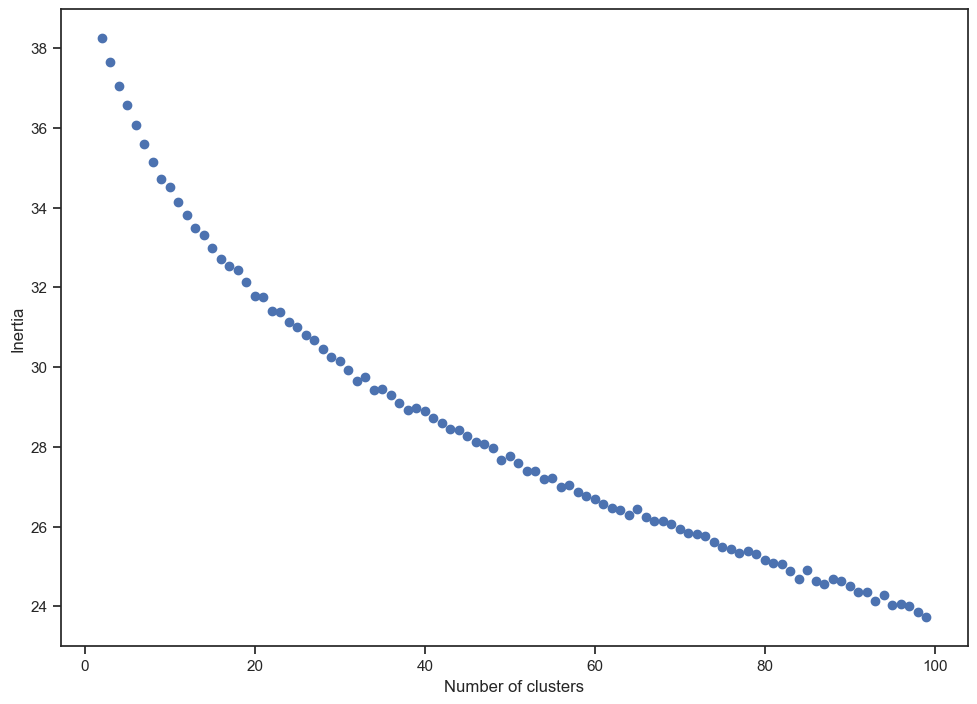

<Figure size 1170x827 with 0 Axes>

In [7]:
plt.scatter(list(range(2,100)), inertia)
ax = plt.gca()
ax.set(xlabel='Number of clusters', ylabel='Inertia')
plt.show()
plt.clf()

Given the plot, the number of clusters should be set to 18 approximately.

In [8]:
nclusters = 18

### Perform clustering

In [9]:
eigenvectors, _, clusterAssignment, clusterCenters = spectral(vectors, nclusters)
transformedVectors = pd.DataFrame(eigenvectors, index=vectors.index)
clusterAssignment = pd.DataFrame({'Cluster': clusterAssignment}, index=vectors.index)

In [10]:
wordsByCluster = {}
for c in range(nclusters):
    wordsByCluster[c] = list(clusterAssignment.loc[clusterAssignment.Cluster == c].index) # list of words contained in cluster c, in the same order as words

In [11]:
# sort clusters by size
clusterSize = [(c,len(v)) for c,v in wordsByCluster.items()]
orderedClusters = sorted(clusterSize, key=lambda x: x[1], reverse=True)

In [12]:
with open('../data/clusters.txt', 'w', encoding='utf-8') as fout:
    for c, _ in orderedClusters:
        fout.write(f'Cluster {c}:\n')
        for w in wordsByCluster[c]:
            fout.write('\t' + w + '\n')

### Project in 2D and plot Voronoi boundaries

In [13]:
custom = {'figure.figsize': (11.7,8.27), 'font.size':11, 'font.family': 'Arial', 'font.sans-serif': 'Arial',
          'axes.spines.right': False, 'axes.spines.left': False, 'axes.spines.top': False, 'axes.spines.bottom': False}
sns.set_theme(style="white", rc=custom)

In [97]:
projected = TSNE(method='exact', init='pca', perplexity=50, random_state=42).fit_transform(np.concatenate((transformedVectors.to_numpy(), clusterCenters)))

In [98]:
centroids = projected[-nclusters:]
projected = pd.DataFrame(projected[:-nclusters], index=transformedVectors.index)

In [99]:
vor = Voronoi(centroids)

In [112]:
labels = ["événement", "variance", "Poisson", "martingale", "moment"] #"Euler", "Poincaré", "Weierstrass", "Kruskal", "Burnside", "quatre", "sept", "dix", "cent", "mille"]

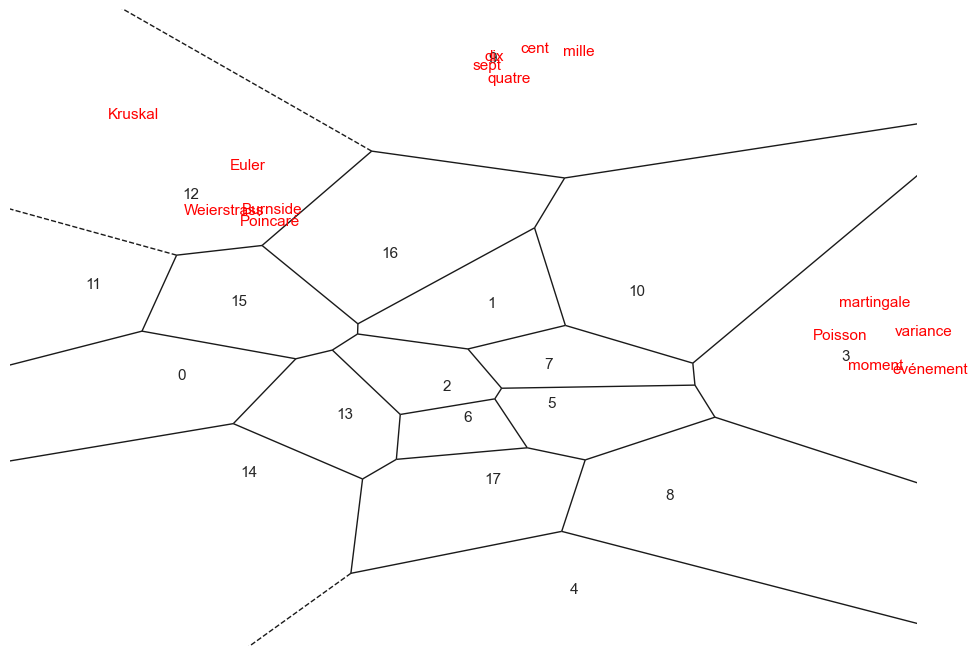

<Figure size 1170x827 with 0 Axes>

In [103]:
fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False)
for i, coord in enumerate(centroids):
    plt.text(coord[0], coord[1], i)
for t in projected.loc[labels].itertuples():
    plt.text(t._1, t._2, t.Index, color='red')
ax = plt.gca()
ax.set(xticklabels=[], yticklabels=[])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.show()
plt.clf()

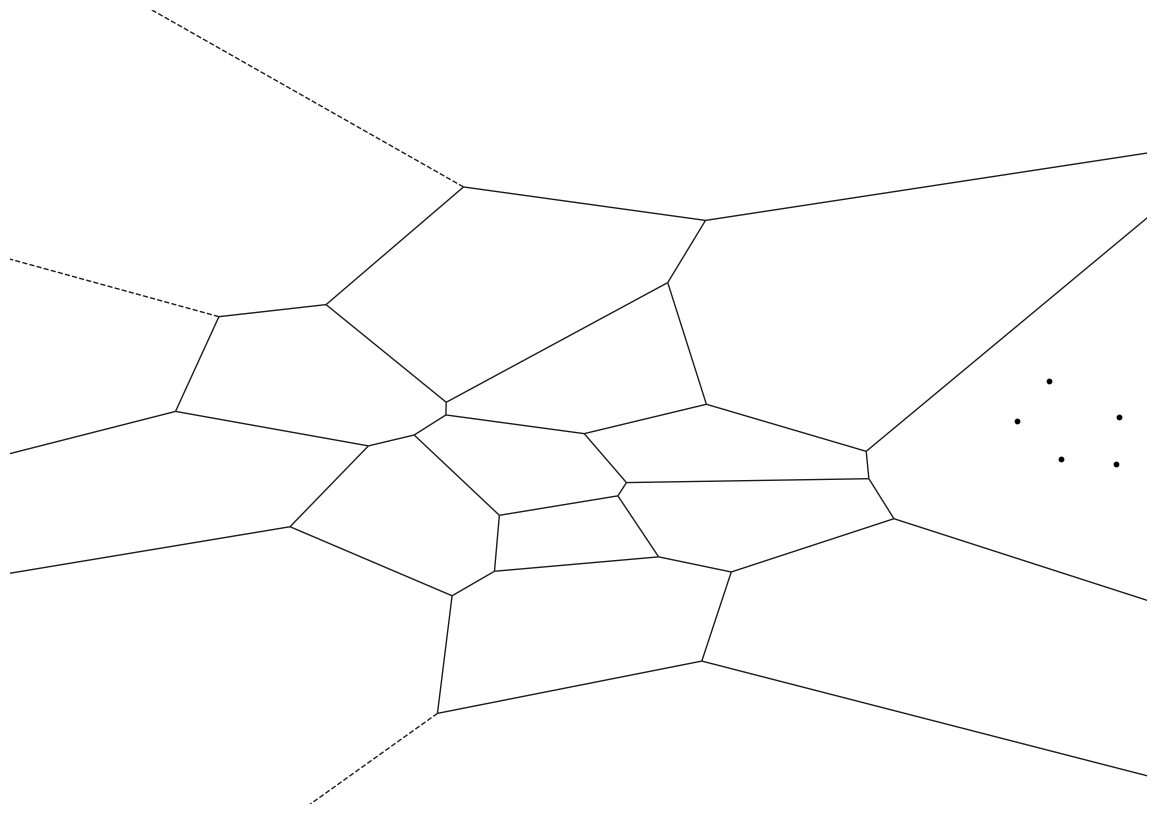

<Figure size 1170x827 with 0 Axes>

In [113]:
fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False)

for t in projected.loc[labels].itertuples():
    plt.scatter(t._1, t._2, color='black', s=10)

ax = plt.gca()
ax.set(xticklabels=[], yticklabels=[])

plt.tight_layout()

plt.show()
plt.clf()